In [100]:
# !pip3 install numpy pandas matplotlib yfinance scikit-learn torch

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

import torch
import torch.nn as nn 
import torch.optim as optim

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error

In [34]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [85]:
ticker = 'BAJFINANCE.NS'  # NSE listed stock
df = yf.download(ticker, '2020-01-01')

[*********************100%***********************]  1 of 1 completed


In [86]:
df

Price,Close,High,Low,Open,Volume
Ticker,BAJFINANCE.NS,BAJFINANCE.NS,BAJFINANCE.NS,BAJFINANCE.NS,BAJFINANCE.NS
Date,,,,,
2020-01-01,4155.185547,4175.513379,4145.071019,4161.568622,407042
2020-01-02,4169.669434,4218.475593,4158.818399,4163.728456,863844
2020-01-03,4118.017090,4158.622889,4097.934759,4144.089308,1176850
2020-01-06,3924.805664,4128.376714,3912.137810,4089.096251,2866735
2020-01-07,3935.558838,4018.391615,3924.314853,3982.057185,2149042
...,...,...,...,...,...
2025-05-05,8919.864258,9020.727031,8853.953931,8865.438306,893061
2025-05-06,8785.547852,8961.808061,8738.112384,8898.893652,1204087


<Axes: xlabel='Date'>

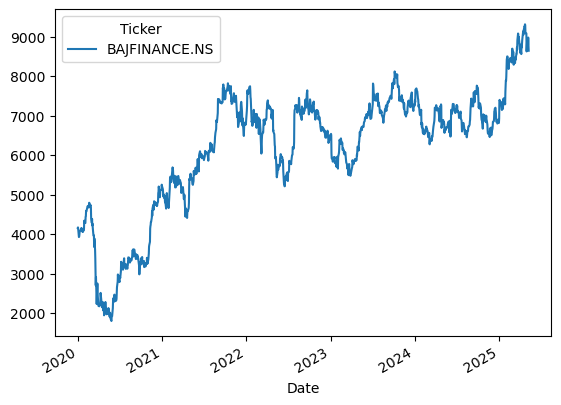

In [87]:
df.Close.plot(fig = (12,8))

In [88]:
scaler = StandardScaler()
df['Close'] = scaler.fit_transform(df['Close'])
df.Close

Ticker,BAJFINANCE.NS
Date,
2020-01-01,-1.263099
2020-01-02,-1.253933
2020-01-03,-1.286624
2020-01-06,-1.408909
2020-01-07,-1.402103
...,...
2025-05-05,1.752510
2025-05-06,1.667500
2025-05-07,1.786957


In [89]:
seq_length = 30
data = []

for i in range(len(df) - seq_length):
    data.append(df.Close[i:i+seq_length])

data = np.array(data)


In [90]:
train_size = int(0.8 * len(data))

X_train = torch.from_numpy(data[:train_size, :-1, :]).type(torch.Tensor).to(device)
y_train = torch.from_numpy(data[:train_size, -1, :]).type(torch.Tensor).to(device)
X_test = torch.from_numpy(data[train_size:, :-1, :]).type(torch.Tensor).to(device)
y_test = torch.from_numpy(data[train_size:, -1, :]).type(torch.Tensor).to(device)

In [91]:
class PredictionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(PredictionModel, self).__init__()

        self.num_layers = num_layers
        self.hidden_dim = hidden_dim

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first = True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self,x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device = device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device = device)

        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1,:])

        return out

In [92]:
model = PredictionModel(input_dim =1, hidden_dim = 32, num_layers =2, output_dim = 1).to(device)

In [93]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.01)

In [94]:
num_epochs = 200

for i in range(num_epochs):
    y_train_pred = model(X_train)

    loss = criterion(y_train_pred, y_train)

    if i % 25 == 0:
        print(i, loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

0 0.9743580222129822
25 0.023357946425676346
50 0.010429348796606064
75 0.008766104467213154
100 0.00802517682313919
125 0.007421894930303097
150 0.0068822456523776054
175 0.006408498622477055


In [95]:
model.eval()
y_test_pred = model(X_test) 

y_train_pred = scaler.inverse_transform(y_train_pred.detach().cpu().numpy())
y_train = scaler.inverse_transform(y_train.detach().cpu().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().cpu().numpy())
y_test = scaler.inverse_transform(y_test.detach().cpu().numpy())


In [96]:
train_rsme = root_mean_squared_error(y_train[:,0], y_train_pred[:,0])
test_rmse = root_mean_squared_error(y_test[:,0], y_test_pred[:, 0])

In [97]:
train_rsme

122.604385

In [98]:
test_rmse

167.22308

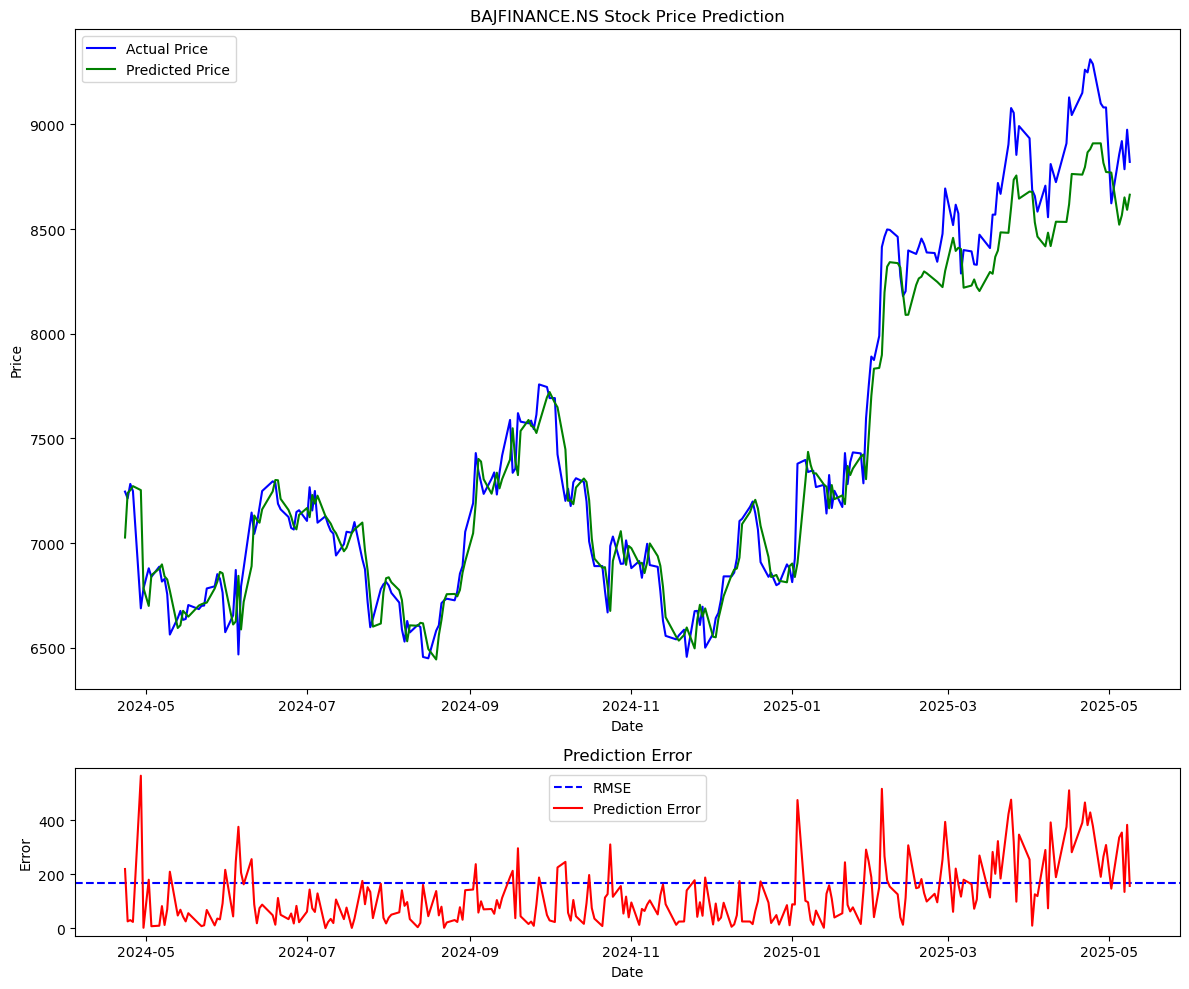

In [99]:
fig = plt.figure(figsize = (12,10))
gs = fig.add_gridspec(4,1)

axl = fig.add_subplot(gs[:3,0])
axl.plot(df.iloc[-len(y_test):].index, y_test, color = 'blue', label = 'Actual Price')
axl.plot(df.iloc[-len(y_test):].index, y_test_pred, color = 'green', label = 'Predicted Price')
axl.legend()
plt.title(f"{ticker} Stock Price Prediction")
plt.xlabel('Date')
plt.ylabel('Price')

ax2 = fig.add_subplot(gs[3,0])
ax2.axhline(test_rmse, color = 'blue', linestyle = '--', label = 'RMSE')
ax2.plot(df[-len(y_test):].index, abs(y_test - y_test_pred), 'r', label = 'Prediction Error')
ax2.legend()
plt.title('Prediction Error')
plt.xlabel('Date')
plt.ylabel('Error')

plt.tight_layout()
plt.show()